# Project: Advanced Lane Lines
<br>
The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detect lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Calibrating the camera

In [1]:
import numpy as np
import glob
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# For the calibration images provided...
nx = 9 # Number of corners on the x-axis
ny = 6 # Number of corners on the y-axis

# Read all the calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Arrays to store object and image points from all images

objpoints = [] # Real world space
imgpoints = [] # Image plane

# Object points: (0,0,0), (1,0,0), (2,0,0), ... , (8,5,0)
# z coordinate is always zero because the board is on the plane
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for filename in images:
    # Read the image
    img = mpimg.imread(filename)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If the image corners are found, add object and image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print('Camera calibrated!')

# Plot calibration image undistorted
# Read the image
image = mpimg.imread(images[0])

# Undistort the calibration image
undistorted_calibration_image = cv2.undistort(image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Distorted Image', fontsize=30)
ax2.imshow(undistorted_calibration_image)
ax2.set_title('Undistorted Image', fontsize=30)

Camera calibrated!


## Correcting for distortion

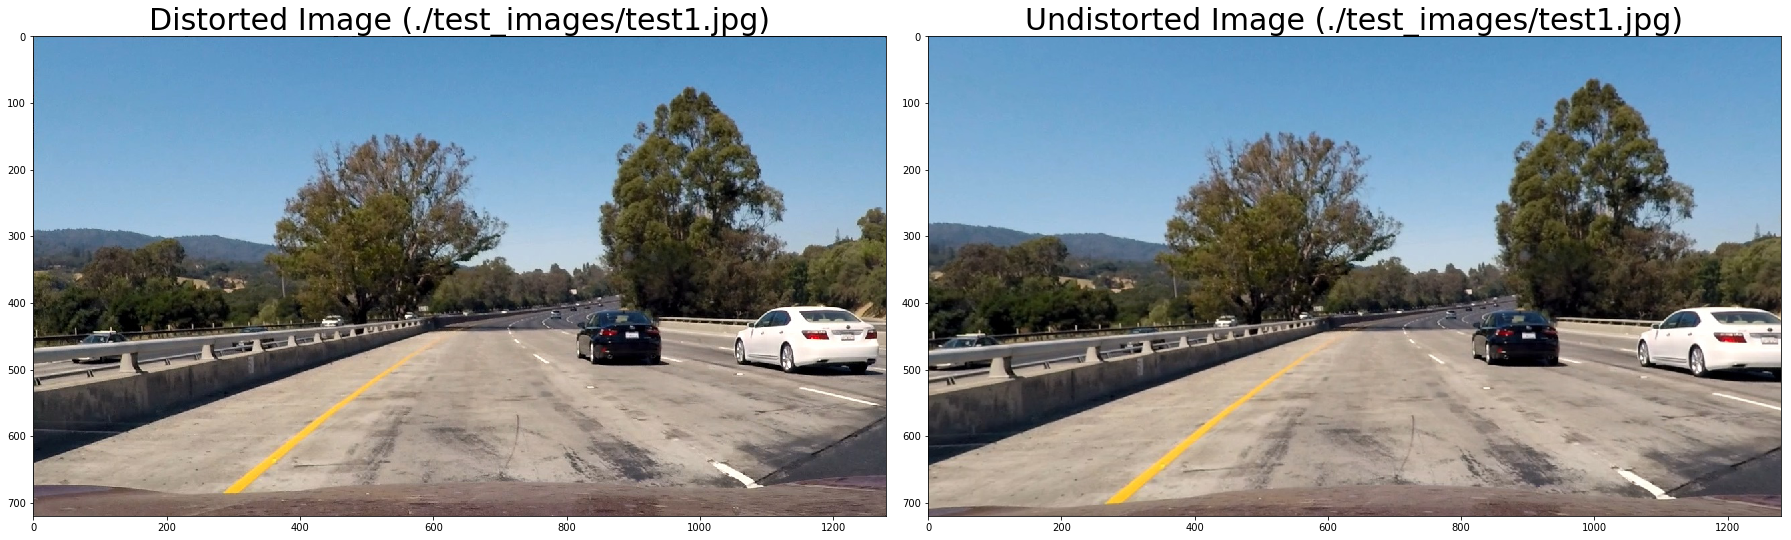

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
%matplotlib inline

test_images = glob.glob('./test_images/test*.jpg')
distorted_images = []
undistorted_images = []

for fn in test_images:
    # Read one of the calibration images
    distorted_image = mpimg.imread(fn)
    distorted_images.append(distorted_image)

    # Undistorting calibration image
    undistorted_images.append(cv2.undistort(distorted_image, mtx, dist, None, mtx))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()
ax1.imshow(distorted_images[0])
ax1.set_title('Distorted Image ({})'.format(str(test_images[0])), fontsize=30)
ax2.imshow(undistorted_images[0])
ax2.set_title('Undistorted Image ({})'.format(str(test_images[0])), fontsize=30)

## Creating a thresholded binary image

The idea on the next cell is to write functions to obtain the thresholds of the x and y gradients, the magnitude of the gradient and the gradient direction and combine them to reach a binary image that best represent the lane lanes of the road.
After that, combine the gradient threshold with a color threshold, specifically using the saturation channel from the HLS color space.

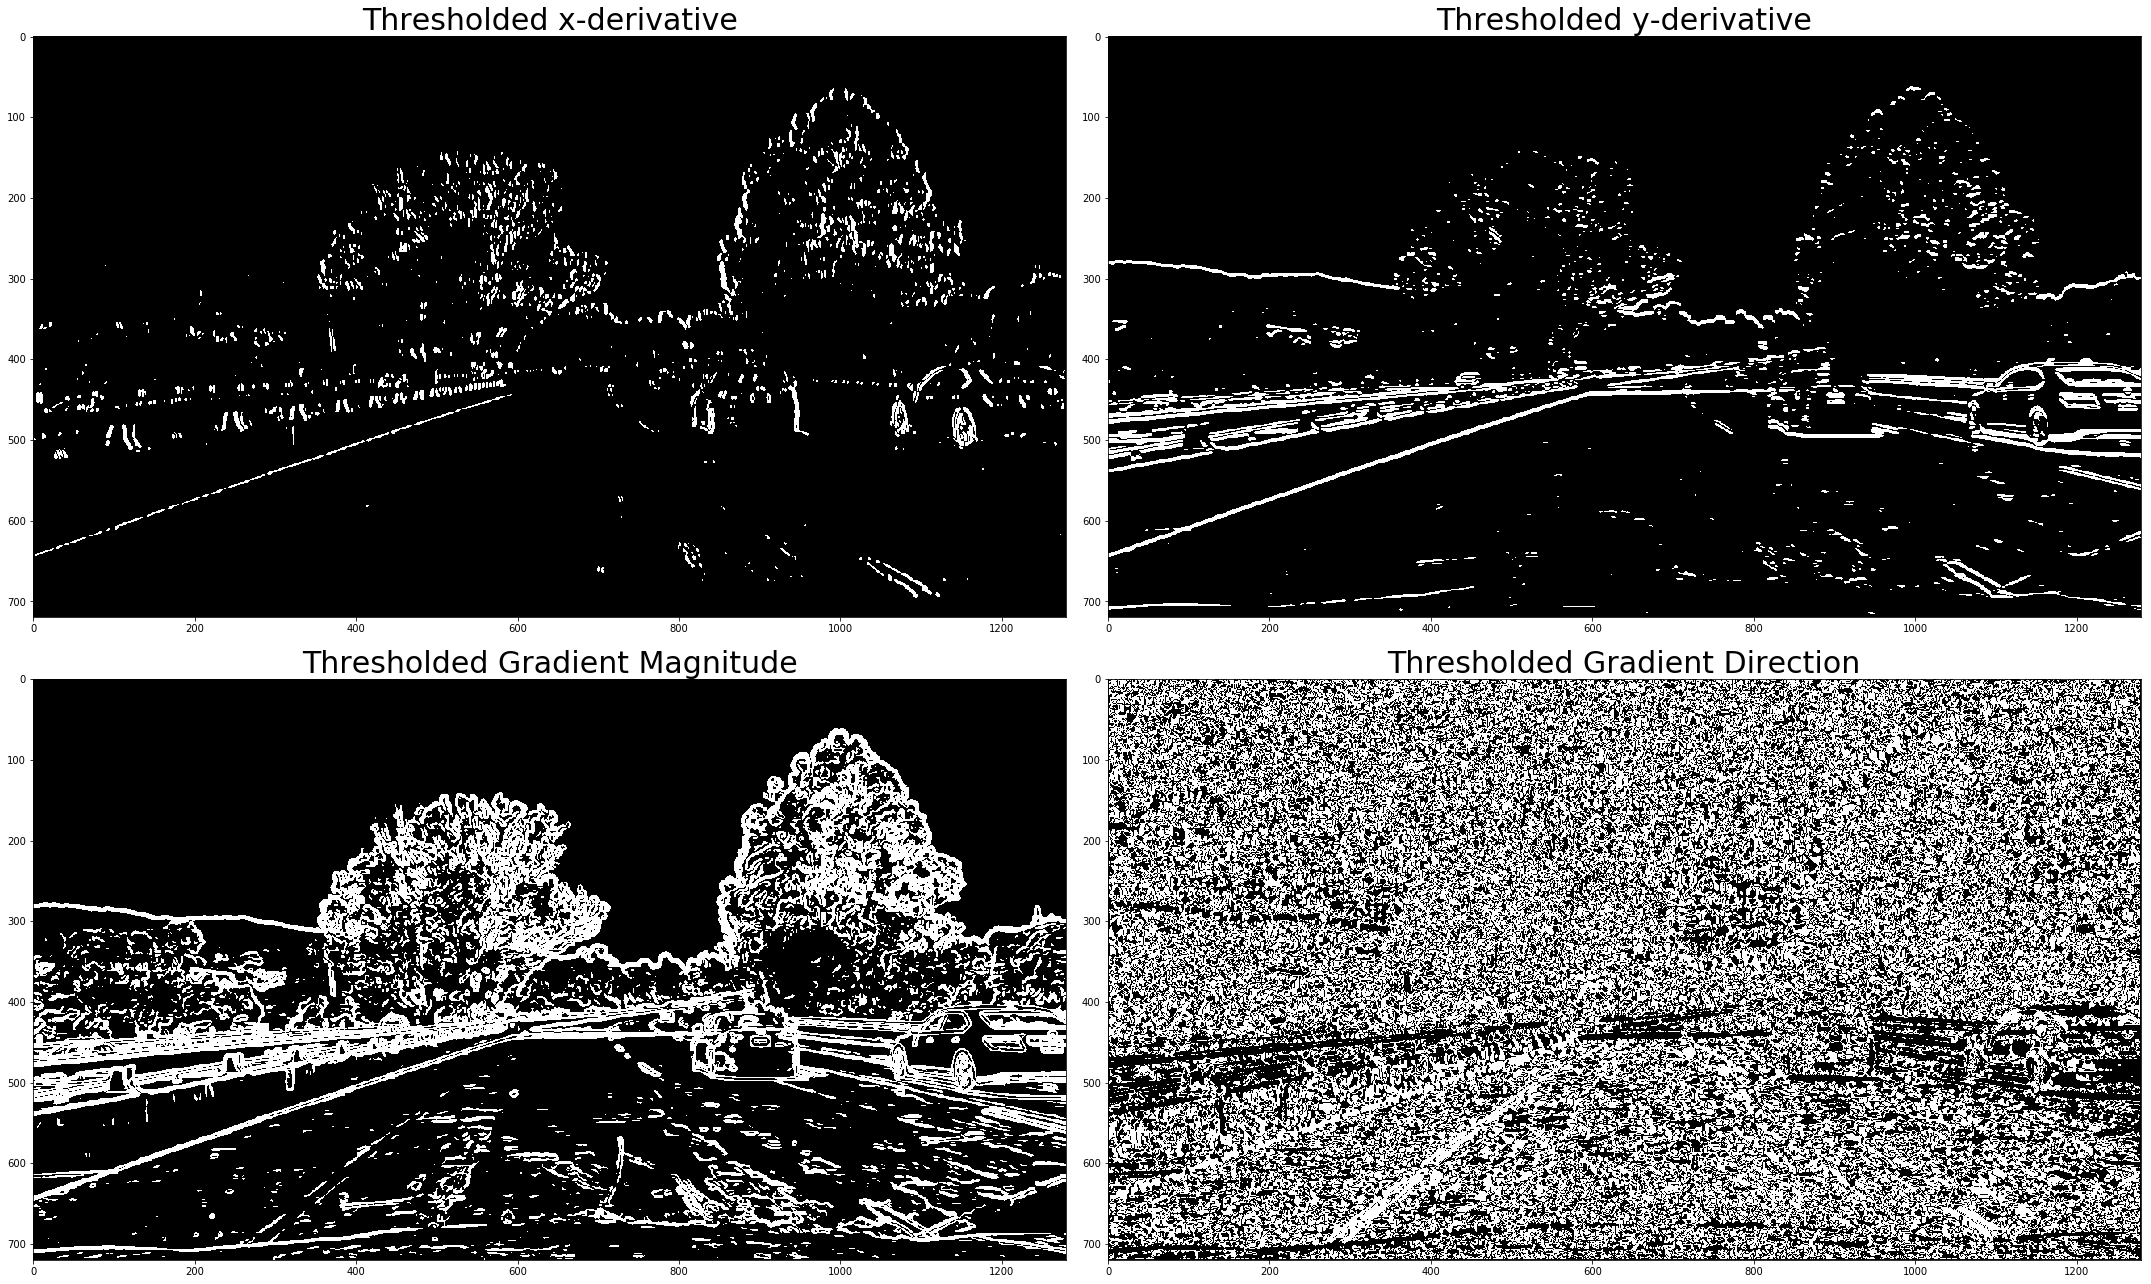

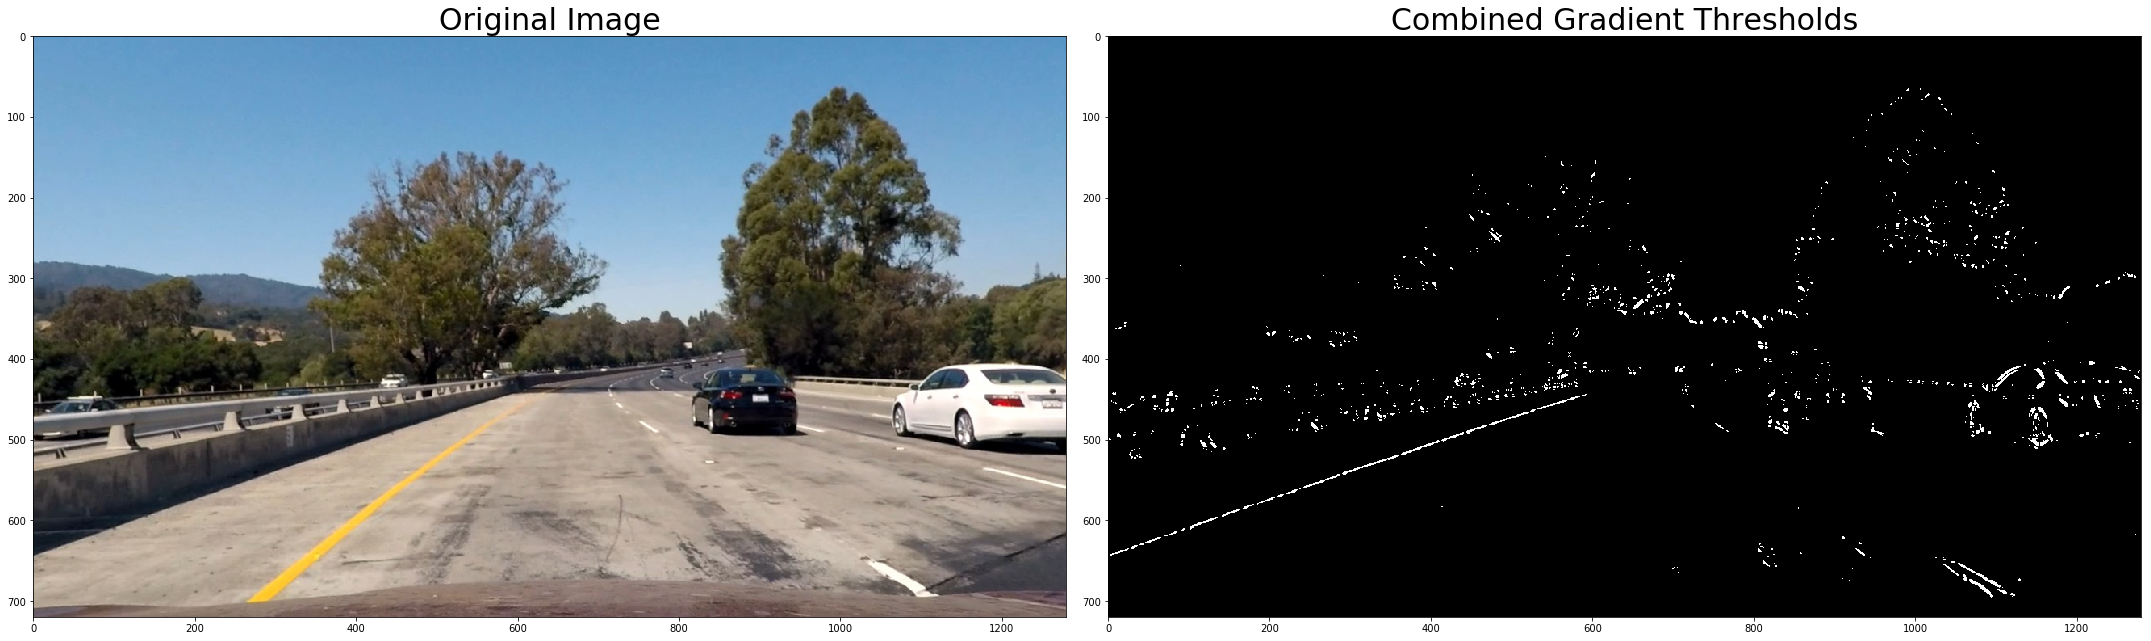

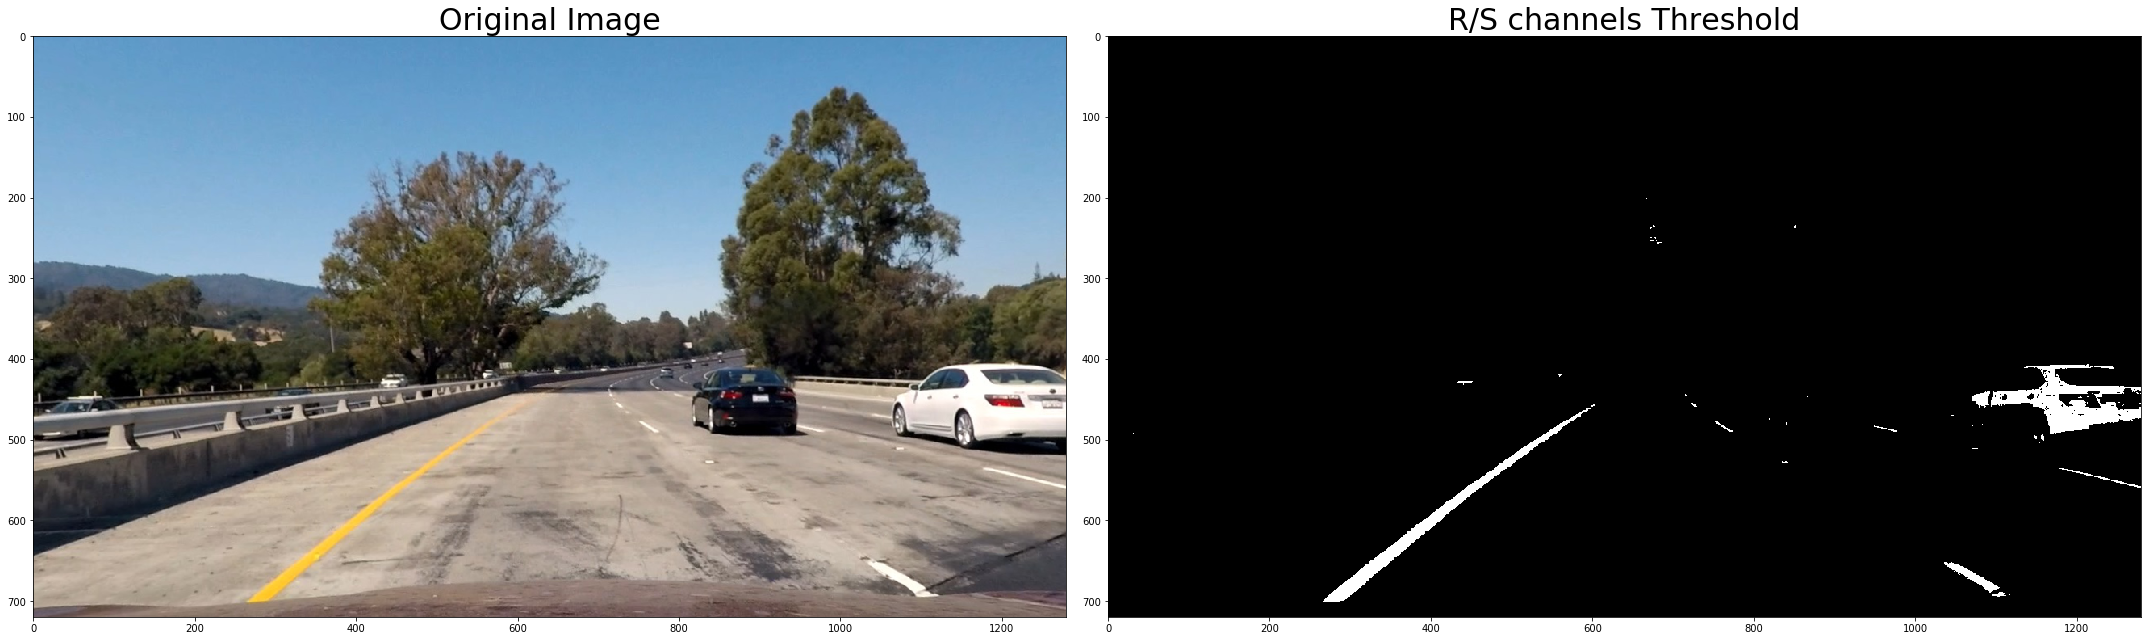

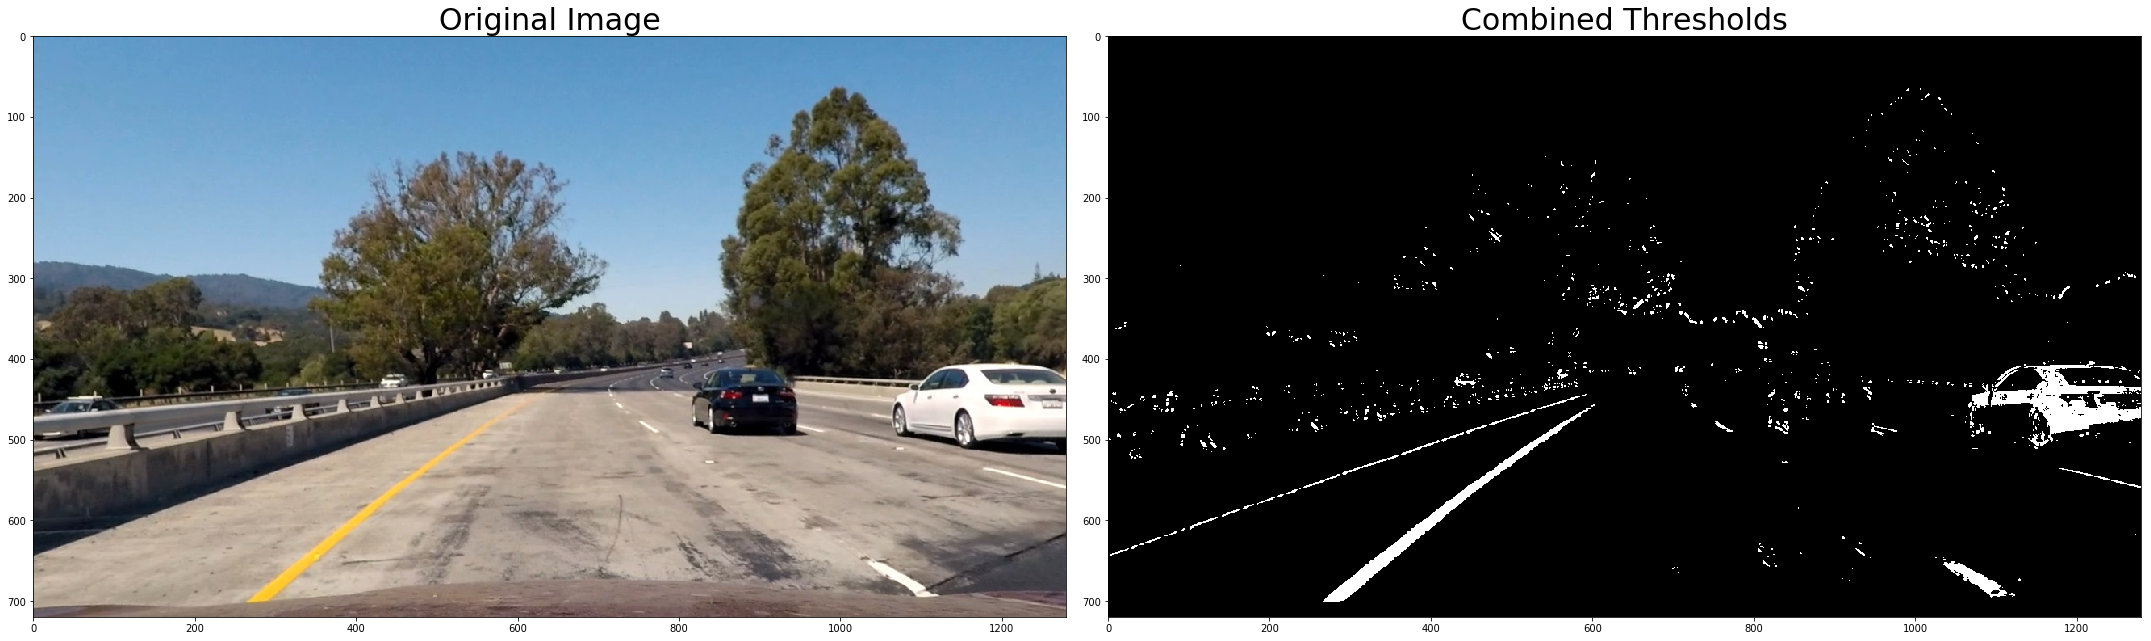

In [3]:
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """ Calculate gradient of the image with respect with the orient 
        variable and apply threshold.
    
    Keyword arguments:
    img          -- image to take the derivative
    orient       -- direction to take the derivative
    sobel_kernel -- kernel size
    thresh       -- threshold to select pixels based on gradient
    
    return binary image
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply Sobel operator
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) 
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the absolute value of the derivative
    abs_sobel = np.absolute(sobel)
    # Convert the absolute value image to 8-bit (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Binary threshold
    binary_img = np.zeros_like(scaled_sobel)
    binary_img[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_img

def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    """ Calculate the magnitude of the gradient and apply threshold.
    
    Keyword arguments:
    img          -- image to take the derivative
    sobel_kernel -- kernel size
    thresh       -- threshold to select pixels based on gradient
    
    return binary image
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply Sobel operator
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude of the gradient
    mag_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # Convert to 8-bit
    scaled_sobel = np.uint8(255*mag_sobelxy/np.max(mag_sobelxy))
    # Binary threshold
    binary_img = np.zeros_like(scaled_sobel)
    binary_img[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_img

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """ Calculate the direction of the gradient and apply threshold.
    
    Keyword arguments:
    img          -- image to take the derivative
    sobel_kernel -- kernel size
    thresh       -- threshold to select pixels based on gradient
    
    return binary image
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply Sobel operator
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the absolute value of the gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Calculate the direction of the gradient
    abs_graddir = np.arctan2(abs_sobely, abs_sobelx)
    # Binary threshold
    binary_img = np.zeros_like(abs_graddir)
    binary_img[(abs_graddir >= thresh[0]) & (abs_graddir <= thresh[1])] = 1
    return binary_img

def color_threshold(img, r_thresh=(0, 255), s_thresh=(0, 255)):
    """ Calculate red from RGB space color and saturation channel 
        from a HLS space color and apply threshold
        
    Keyword arguments:
    img          -- image to take the derivative
    s_thresh     -- threshold for saturation to select pixels based on gradient
    r_thresh     -- threshold for red to select pixels based on gradient
    
    return binary image
    """
    # Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Select saturation channel
    r_channel = img[:,:,0]
    s_channel = hls[:,:,2]
    # Binary threshold
    rbinary = np.zeros_like(r_channel)
    sbinary = np.zeros_like(s_channel)
    binary = np.zeros_like(s_channel)
    rbinary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    sbinary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    binary[(rbinary == 1) & (sbinary == 1)] = 1
    return binary
    
def apply_thresholds(undistorted_image):
    """
    """
    # Gradient thresholds
    gradx_image = abs_sobel_threshold(undistorted_image, orient='x', sobel_kernel=9, thresh=(40, 200))
    grady_image = abs_sobel_threshold(undistorted_image, orient='y', sobel_kernel=9, thresh=(40, 200))
    
    # Color threshold
    colorbinary = color_threshold(undistorted_image, r_thresh=(140, 255), s_thresh=(140, 255))
    
    # Combine gradient thresholds
    gradbinary = np.zeros_like(dir_image)
    gradbinary[((gradx_image == 1) & (grady_image == 1))] = 1

    # Combine gradient and color thresholds
    combined_binary = np.zeros_like(colorbinary)
    combined_binary[(colorbinary == 1) | (gradbinary == 1)] = 1
    
    return combined_binary

# Image used on test
undistorted_image = undistorted_images[0]

# Gradient thresholds
gradx_image = abs_sobel_threshold(undistorted_image, orient='x', sobel_kernel=9, thresh=(40, 200))
grady_image = abs_sobel_threshold(undistorted_image, orient='y', sobel_kernel=9, thresh=(40, 200))
mag_image = mag_threshold(undistorted_image, sobel_kernel=9, thresh=(20, 150))
dir_image = dir_threshold(undistorted_image, sobel_kernel=9, thresh=(0.4, 1.3))

# Color threshold
colorbinary = color_threshold(undistorted_image, r_thresh=(140, 255), s_thresh=(140, 255))

# Combine gradient thresholds
gradbinary = np.zeros_like(dir_image)
gradbinary[((gradx_image == 1) & (grady_image == 1))] = 1

# Combine gradient and color thresholds
combined_binary = apply_thresholds(undistorted_image)

# Plot images
f1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(30, 18))
f1.tight_layout()
ax1.imshow(gradx_image, cmap='gray')
ax1.set_title('Thresholded x-derivative', fontsize=30)
ax2.imshow(grady_image, cmap='gray')
ax2.set_title('Thresholded y-derivative', fontsize=30)
ax3.imshow(mag_image, cmap='gray')
ax3.set_title('Thresholded Gradient Magnitude', fontsize=30)
ax4.imshow(dir_image, cmap='gray')
ax4.set_title('Thresholded Gradient Direction', fontsize=30)

f2, (ax5, ax6) = plt.subplots(1, 2, figsize=(30, 18))
f2.tight_layout()
ax5.imshow(undistorted_image)
ax5.set_title('Original Image', fontsize=30)
ax6.imshow(gradbinary, cmap='gray')
ax6.set_title('Combined Gradient Thresholds', fontsize=30)

f3, (ax7, ax8) = plt.subplots(1, 2, figsize=(30, 18))
f3.tight_layout()
ax7.imshow(undistorted_image)
ax7.set_title('Original Image', fontsize=30)
ax8.imshow(colorbinary, cmap='gray')
ax8.set_title('R/S channels Threshold', fontsize=30)

f4, (ax9, ax10) = plt.subplots(1, 2, figsize=(30, 18))
f4.tight_layout()
ax9.imshow(undistorted_image)
ax9.set_title('Original Image', fontsize=30)
ax10.imshow(combined_binary, cmap='gray')
ax10.set_title('Combined Thresholds', fontsize=30)

## Perspective Transform

Using a image of straight line lanes, the next cell will compute the perspective transform for the given source and destination points. After the transformation, any image will be a bird's eye view perspective.

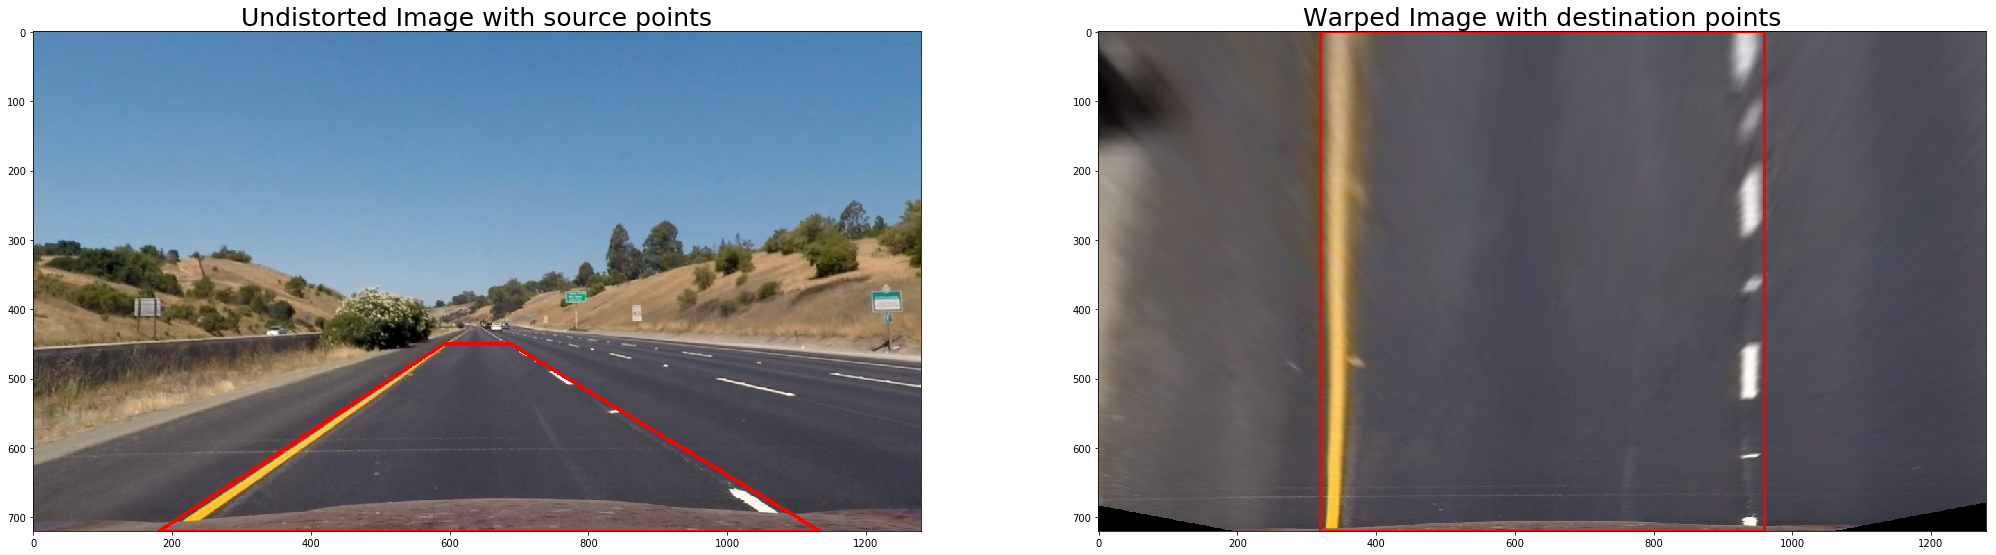

In [4]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

def draw_lines(image, points, thickness=1):
    """ Draw lines to create a closed polygon.
    
    Keyword arguments:
    image        -- image to draw the lines
    points       -- threshold for saturation to select pixels based on gradient
    thickness    -- thickness of the lines
    
    return image with lines
    """
    for i in range(len(points)-1):
        cv2.line(image, tuple(points[i]), tuple(points[i+1]), (255,0,0), thickness)
    cv2.line(image, tuple(points[len(points)-1]), tuple(points[0]), (255,0,0), thickness)

def warper(image, src, dst):
    """
    """
    image_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    
# Read the straight line image to create the perspective transform
straight_line = mpimg.imread('./test_images/straight_lines1.jpg')

# undistorted the straight line image
undist_straight = cv2.undistort(straight_line, mtx, dist, None, mtx)

# Get the dimension of the image
img_size = straight_line.shape

# Four points selected from the source image (undistorted)
src = np.float32([
    [(img_size[1] / 2) - 48, img_size[0] / 2 + 90],
    [(img_size[1] / 2) + 48, img_size[0] / 2 + 90],
    [(img_size[1] * 4 / 5) + 110, img_size[0]],
    [(img_size[1] / 5) - 75, img_size[0]]
])

# Four points selected to the destination image (warped)
dst = np.float32([
    [(img_size[1] / 4), 0],
    [(img_size[1] * 3 / 4), 0],
    [(img_size[1] * 3 / 4), img_size[0]],
    [(img_size[1] / 4), img_size[0]]
])

warped = warper(undist_straight, src, dst)
draw_lines(undist_straight, src, thickness=4)
draw_lines(warped, dst, thickness=4)

# Plot the images
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(35, 18))
ax1.imshow(undist_straight)
ax1.set_title('Undistorted Image with source points', fontsize=25)
ax2.imshow(warped)
ax2.set_title('Warped Image with destination points', fontsize=25)

## Finding the lines

712.411796871 m
440.863734154 m
-0.152588373867 m


(720, 0)

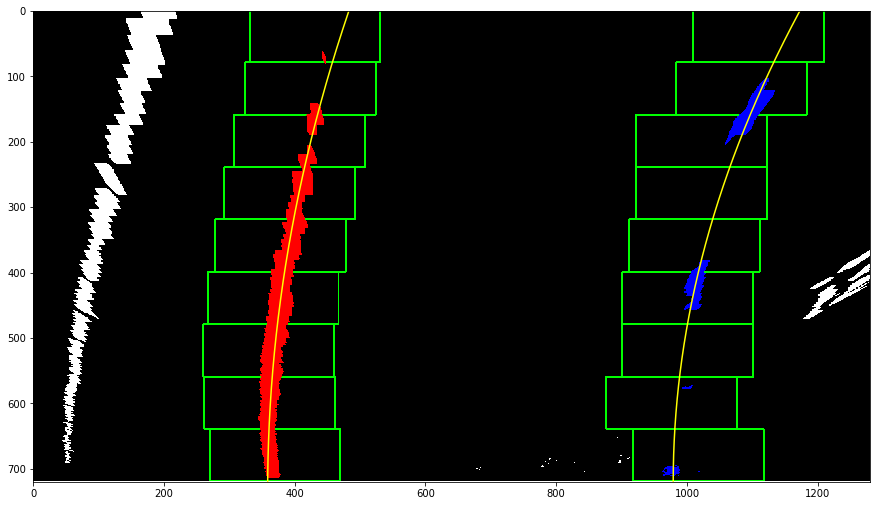

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

binary_warped = warper(combined_binary, src, dst)

def slidingWindows(binary, draw_windows=False):
    """
    Apply the sliding windows algorithm to find the left and right lines on the binary warped image
    and fit a 2nd order polinomial to each
    
    Keyword arguments:
    binary        -- binary warped image of the road
    draw_windows  -- determine when the windows will be draw on the out_img image
    
    return left_fit, right_fit, leftpx, rightpx, out_img
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary, binary, binary))*255
    # Find the peak of the leaf and right halves of the histogram
    # These will be the starting point for the left an right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image if draw_windows=True
        if draw_windows:
            cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2)
            cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append the indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window no their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    leftpx = (leftx, lefty)
    rightpx = (rightx, righty)
    
    # Fit a second order polynomial to each (in pixels)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftpx, rightpx, out_img

def laneCurvaturesAndOffset(image, leftpx, rightpx):
    """
    Calculate the radius of curvature for the left and right lanes.
    Also calculate the distance between the center of the vehicle and
    the left and right lines.
    
    Keyword arguments:
    image         -- image used to calculate the curvatures and the offset
    leftpx        -- position of the pixels from the left lane line
    rightpx       -- position of the pixels from the right lane line
    
    return curverad, line_pos
    """
    y_eval = image.shape[0] - 1
    x_eval = image.shape[1]
    
    # Convert x and y from pixels to meters
    ym_per_px = 30/720
    xm_per_px =  3.7/700
    
    # x and y for the base in meters
    y_eval_m = y_eval * ym_per_px
    x_eval_m = x_eval * xm_per_px
    
    # Fit new polynomials to x,y in meters
    left_fit_cr = np.polyfit(leftpx[1]*ym_per_px, leftpx[0]*xm_per_px, 2)
    right_fit_cr = np.polyfit(rightpx[1]*ym_per_px, rightpx[0]*xm_per_px, 2)
    
    # Evaluate the curvature radius for the base of the image (y_eval)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_m+left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_m+right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curverad = (left_curverad, right_curverad)
    
    # Evaluate the distance between the vehicle's center and the left and right lines
    midpoint_image_m = x_eval_m / 2
    xl = left_fit_cr[0]*y_eval_m**2 + left_fit_cr[1]*y_eval_m + left_fit_cr[2] # x-coordinate for the left lane
    xr = right_fit_cr[0]*y_eval_m**2 + right_fit_cr[1]*y_eval_m + right_fit_cr[2] # x-coordinate for the right lane
    left_line_pos = midpoint_image_m - xl
    right_line_pos = xr - midpoint_image_m
    
    line_pos = (left_line_pos, right_line_pos)
    
    return curverad, line_pos

def drawLaneArea(image, warped, left_fit, right_fit):
    """
    Draw the lane area of the road.
    
    Keyword arguments:
    image           -- undistorted image
    warped          -- bird's eye view image
    left_fit        -- coefficients from the second order fit of the left line
    right_fit       -- coefficients from the second order fit of the right line
    
    return result
    """
    # x and y pixel values of the lines
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

left_fit, right_fit, \
leftpx, rightpx, out_img = slidingWindows(binary_warped, draw_windows=True)
curverad, line_pos = laneCurvaturesAndOffset(binary_warped, leftpx, rightpx)

print(curverad[0], 'm')
print(curverad[1], 'm')
offset = (2*line_pos[0]-(line_pos[0]+line_pos[1]))/2
print(offset, 'm')

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[leftpx[1], leftpx[0]] = [255, 0, 0]
out_img[rightpx[1], rightpx[0]] = [0, 0, 255]
plt.figure(figsize=(15,12))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

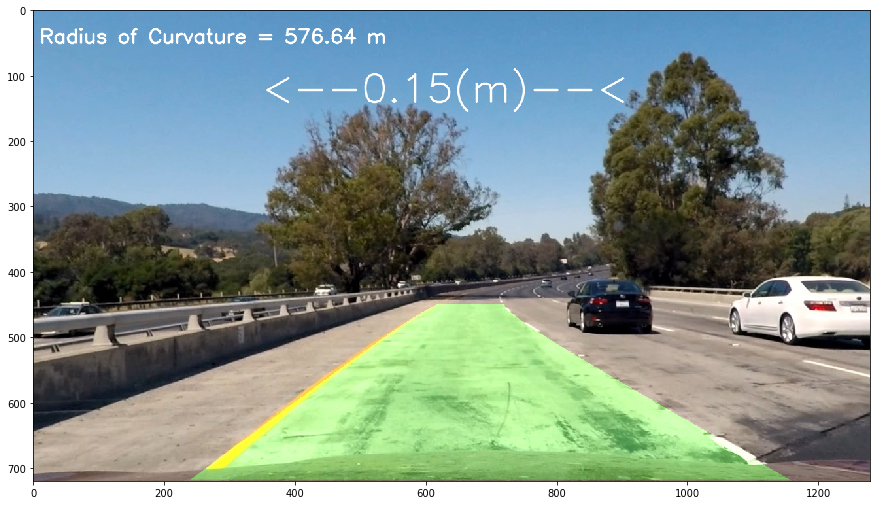

In [6]:
import matplotlib.pyplot as plt

final_image = drawLaneArea(undistorted_image, binary_warped, left_fit, right_fit)
rad = np.mean(curverad)
offset = (2*line_pos[0]-(line_pos[0]+line_pos[1]))/2
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(final_image, 'Radius of Curvature = {0:.2f} m'.format(rad), 
            (10,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
if offset < 0:
    cv2.putText(final_image, '<--{0:.2f}(m)--<'.format(np.absolute(offset)), 
                (350,140), font, 2, (255,255,255), 2, cv2.LINE_AA)
elif offset > 0:
    cv2.putText(final_image, '>--{0:.2f}(m)-->'.format(np.absolute(offset)),
                (350,140), font, 2, (255,255,255), 2, cv2.LINE_AA)

plt.figure(figsize=(15,12))
plt.imshow(final_image)

In [7]:
import numpy as np

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        # average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the line in meters
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None
        
def process_frame(image):
    """
    """
    global left_line, right_line
    # Undistort image
    undistort_image = cv2.undistort(image, mtx, dist, None, mtx)
    # Apply the gradient and color thresholds
    binary = apply_thresholds(undistort_image)
    # Warp the undistort image
    binary_warped = warper(binary, src, dst)
    # Sliding windows algorithm 
    left_fit, right_fit, \
    leftpx, rightpx, out_img = slidingWindows(binary_warped)
    # Radius of curvature and vehicle offset
    curverad, line_pos = laneCurvaturesAndOffset(binary_warped, leftpx, rightpx)
    
    # If some line is detected
    if left_line.detected & right_line.detected:
        # If a detected line diverge from the previous detection, maintain the previous lines
        if (float(np.absolute(left_line.line_base_pos-line_pos[0])) > 0.3) \
        | (float(np.absolute(right_line.line_base_pos-line_pos[1])) > 0.3):
            # Draw lane area
            image_wLanes = drawLaneArea(image, binary_warped, 
                                        left_line.current_fit, right_line.current_fit)
            rad = np.mean([left_line.radius_of_curvature, right_line.radius_of_curvature])
            offset = (2*left_line.line_base_pos-(left_line.line_base_pos+right_line.line_base_pos))/2
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image_wLanes, 'Radius of Curvature = {0:.2f} m'.format(rad),
                        (10,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
            if offset < 0:
                cv2.putText(image_wLanes, '<--{0:.2f}(m)--<'.format(np.absolute(offset)),
                            (350,140), font, 2, (255,255,255), 2, cv2.LINE_AA)
            elif offset > 0:
                cv2.putText(image_wLanes, '>--{0:.2f}(m)-->'.format(np.absolute(offset)),
                            (350,140), font, 2, (255,255,255), 2, cv2.LINE_AA)
        else:
            # Draw lane area
            image_wLanes = drawLaneArea(image, binary_warped, left_fit, right_fit)
            rad = np.mean(curverad)
            offset = (2*line_pos[0]-(line_pos[0]+line_pos[1]))/2
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image_wLanes, 'Radius of Curvature = {0:.2f} m'.format(rad),
                        (10,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
            if offset < 0:
                cv2.putText(image_wLanes, '<--{0:.2f}(m)--<'.format(np.absolute(offset)),
                            (350,140), font, 2, (255,255,255), 2, cv2.LINE_AA)
            elif offset > 0:
                cv2.putText(image_wLanes, '>--{0:.2f}(m)-->'.format(np.absolute(offset)),
                            (350,140), font, 2, (255,255,255), 2, cv2.LINE_AA)

            # Store info in lines instances
            # Left Line
            left_line.current_fit = left_fit
            left_line.radius_of_curvature = curverad[0]
            left_line.line_base_pos = line_pos[0]
            # Right Line
            right_line.current_fit = right_fit
            right_line.radius_of_curvature = curverad[1]
            right_line.line_base_pos = line_pos[1]
    
    # If no line is detected (first frame)
    elif (not left_line.detected) & (not right_line.detected):
        # Draw lane area
        image_wLanes = drawLaneArea(image, binary_warped, left_fit, right_fit)
        rad = np.mean(curverad)
        offset = (2*line_pos[0]-(line_pos[0]+line_pos[1]))/2
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image_wLanes, 'Radius of Curvature = {0:.2f} m'.format(rad),
                    (10,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
        if offset < 0:
            cv2.putText(image_wLanes, '<--{0:.2f}(m)--<'.format(np.absolute(offset)),
                        (350,140), font, 2, (255,255,255), 2, cv2.LINE_AA)
        elif offset > 0:
            cv2.putText(image_wLanes, '>--{0:.2f}(m)-->'.format(np.absolute(offset)),
                        (350,140), font, 2, (255,255,255), 2, cv2.LINE_AA)

        # Store info in lines instances
        # Left Line
        left_line.current_fit = left_fit
        left_line.radius_of_curvature = curverad[0]
        left_line.line_base_pos = line_pos[0]
        # Right Line
        right_line.current_fit = right_fit
        right_line.radius_of_curvature = curverad[1]
        right_line.line_base_pos = line_pos[1]

        # left and right lane lines detected
        left_line.detected = True
        right_line.detected = True
    
    return image_wLanes

# Create left and right lane lines instances
left_line = Line()
right_line = Line()

In [8]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip_output = 'output_videos/project_video_output.mp4'

clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_frame)
%time clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [06:29<00:00,  3.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

CPU times: user 7min 36s, sys: 1min 1s, total: 8min 37s
Wall time: 6min 31s


In [9]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(clip_output))